##Citation

Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M.,Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., and Houlsby, N. (2020).  An image is worth16x16 words: Transformers for image recognition at scale.CoRR, abs/2010.11929.

https://github.com/rwightman/pytorch-image-models

## installation

In [1]:
pip install timm

     |████████████████████████████████| 296kB 9.1MB/s 


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision as tv
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import time
import os
import copy
import requests
import io

plt.ion()   # interactive mode

import timm 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()
print(device)

cuda:0


In [4]:
all_vit_models = timm.list_models('*vit*', pretrained=True)
all_vit_models

['vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_384',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_deit_base_distilled_patch16_224',
 'vit_deit_base_distilled_patch16_384',
 'vit_deit_base_patch16_224',
 'vit_deit_base_patch16_384',
 'vit_deit_small_distilled_patch16_224',
 'vit_deit_small_patch16_224',
 'vit_deit_tiny_distilled_patch16_224',
 'vit_deit_tiny_patch16_224',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224_in21k',
 'vit_large_patch32_384',
 'vit_small_patch16_224']

In [5]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

## download dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Before you do the following, make sure to first upload a Kaggle token json 
# file to /content/gdrive/MyDrive/Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
# /content/gdrive/MyDrive/Kaggle is the path where kaggle.json is present in the Google Drive
!mkdir /content/gdrive/MyDrive/Kaggle/CoronaHack
%cd /content/gdrive/MyDrive/Kaggle/CoronaHack

# Download dataset from Kaggle
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset
!unzip \*.zip  && rm *.zip

## label dataset

In [ ]:
metadata_path = "/content/gdrive/MyDrive/Kaggle/CoronaHack/Chest_xray_Corona_Metadata.csv"
metadata = pd.read_csv(metadata_path, index_col=0)
metadata.head()

In [ ]:
normal_meta = metadata[metadata["Label"] == "Normal"]
virus_meta = metadata[metadata["Label_1_Virus_category"] == "Virus"]
# covid_meta = metadata[metadata["Label_2_Virus_category"] == "COVID-19"]
# other_meta = metadata[(metadata["Label"] == "Pnemonia") & (metadata["Label_2_Virus_category"] != "COVID-19")]
print(normal_meta.shape[0], virus_meta.shape[0])

In [ ]:
data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack/data1"
!mkdir $data_dir
normal_dir = f"{data_dir}/normal"
virus_dir = f"{data_dir}/virus"
# covid_dir = f"{data_dir}/covid19"
# other_dir = f"{data_dir}/other"
dir_dict = {
    normal_dir: normal_meta, 
    virus_dir: virus_meta,
    # covid_dir: covid_meta,
    # other_dir: other_meta,
}
for dir in dir_dict.keys():
  if not os.path.exists(dir):
    os.mkdir(dir)
old_data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"

for dir, meta in dir_dict.items():
  for im in meta["X_ray_image_name"]:
    if os.path.exists(f"{old_data_dir}/train/{im}"):
      os.rename(f"{old_data_dir}/train/{im}", f"{dir}/{im}")
    elif os.path.exists(f"{old_data_dir}/test/{im}"):
      os.rename(f"{old_data_dir}/test/{im}", f"{dir}/{im}")

## Load dataset

In [6]:
# config 
input_size = 3, 128, 128
img_size = 128
num_classes = 2
batch_size = 32

interpolation = 'bicubic'
IMAGENET_DEFAULT_MEAN  = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
DEFAULT_CROP_PCT = 0.9

### Create dataset and dataloader

#### option1: using the same default settings as train.py in the code source

In [ ]:
data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack/data1"
from timm.data import create_dataset, create_loader
# create the train and eval datasets
train_dataset = create_dataset(name='', root=data_dir, split='train', is_training=True,
        batch_size=batch_size)
val_dataset = create_dataset(name='', root=data_dir, split='validation', 
                              is_training=False, batch_size=batch_size)
train_len, val_len = len(train_dataset), len(val_dataset)

# create data loaders 
loader_train = create_loader(
        train_dataset,
        input_size=input_size,
        batch_size=batch_size,
        is_training=True,
        scale=[0.08, 1.0],
        ratio=[3./4., 4./3.],
        interpolation=interpolation,
        mean=IMAGENET_DEFAULT_MEAN,
        std=IMAGENET_DEFAULT_STD,
        num_workers=2)

loader_val = create_loader(
        val_dataset,
        input_size=input_size,
        batch_size=batch_size,
        is_training=False,
        interpolation=interpolation,
        mean=IMAGENET_DEFAULT_MEAN,
        std=IMAGENET_DEFAULT_STD,
        crop_pct=DEFAULT_CROP_PCT)

####option2: use same dataset and dataloader as BiT experiment

In [9]:
data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack/data1"
data_transforms = transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        # tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

image_datasets = datasets.ImageFolder(data_dir, data_transforms)

In [10]:
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes
print(dataset_sizes, class_names)

3131 ['normal', 'virus']


In [11]:
val_size = int(dataset_sizes*0.15)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [dataset_sizes-2*val_size, val_size, val_size], generator=torch.Generator().manual_seed(42))
train_len, val_len = len(train_dataset), len(val_dataset)

In [12]:
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)
loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # if use option1 dataloader
    # inp = inp.cpu().numpy().transpose((1, 2, 0))
    # if use option2 dataloader
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.5, 0.5, 0.5])
    # std = np.array([0.5, 0.5, 0.5])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(loader_train))

# Make a grid from batch
out = tv.utils.make_grid(inputs)

imshow(out)


## Fine-Tuning

In [13]:
def eval_corona(model, loader_val):
  model.eval()

  preds = []
  with torch.no_grad():
    for x, t in loader_val:
      x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
      logits = model(x)
      preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

  return sum(preds) / val_len

In [ ]:
# ViT-B/16
# model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=num_classes, img_size=img_size)
# R50+ViT-B/16
model = timm.create_model('vit_base_resnet50_224_in21k', pretrained=True, num_classes=num_classes, img_size=img_size)
model.to(device)

### Use the default optimizer, loss_fn and lr_scheduler as train.py in the code source

In [15]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

# weight_decay
skip = {}
if hasattr(model, 'no_weight_decay'):
    skip = model.no_weight_decay()
parameters = add_weight_decay(model, 0.0001, skip)
weight_decay = 0.

optimizer = optim.SGD(parameters, momentum=0.9, nesterov=True, lr=0.01, weight_decay=weight_decay)

In [16]:
from timm.loss import LabelSmoothingCrossEntropy
loss_fn = LabelSmoothingCrossEntropy(smoothing=0.1).cuda()

In [17]:
from timm.scheduler import StepLRScheduler
# setup learning rate schedule and starting epoch
start_epoch = 0

num_epochs = 10

noise_range = None
lr_scheduler = StepLRScheduler(optimizer, decay_t=30, decay_rate=0.1,
               warmup_lr_init=0.0001, warmup_t=3, noise_range_t=None, noise_pct=0.67,
               noise_std=1., noise_seed=42)

### train and evaluate the model

In [ ]:
iters = 10

pb_train = display(progress(0, iters), display_id=True)
losses = [[]]
accus_train = [[]]
accus_val = []

for i in range(iters):
  for x, t in loader_train:
    x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
    logits = model(x)
    # print(logits.mean())
    loss = loss_fn(logits, t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].append(torch.sum(torch.max(logits, dim=1)[1] == t))
      #print(torch.max(logits, dim=1)[1])
    # break

  losses[-1] = sum(losses[-1])
  losses.append([])
  accus_train[-1] = sum(accus_train[-1]) / train_len
  accus_train.append([])

  # step LR for next epoch
  lr_scheduler.step(i + 1)

  accus_val.append(eval_corona(model, loader_val))
  model.train()

  pb_train.update(progress(i, iters))
  print(f'\r[Step {i+1}] loss={loss:.2e} '
        f'\r[Step {i+1}] loss={losses[-2]:.2e} '
        f'train accu={accus_train[-2]:.2%} '
        f'validation accu={accus_val[-1]:.2%} '
        # , end=''
        , flush=True)
  # break

[Step 1] loss=4.50e+01 train accu=63.84% validation accu=75.69% 
[Step 2] loss=2.89e+01 train accu=86.96% validation accu=88.91% 
[Step 3] loss=2.76e+01 train accu=86.91% validation accu=85.29% 
[Step 4] loss=2.65e+01 train accu=88.60% validation accu=90.19% 
[Step 5] loss=2.49e+01 train accu=90.61% validation accu=90.19% 
[Step 6] loss=2.47e+01 train accu=89.83% validation accu=89.98% 
[Step 7] loss=2.36e+01 train accu=91.24% validation accu=91.68% 
[Step 8] loss=2.29e+01 train accu=92.16% validation accu=90.83% 
[Step 9] loss=2.32e+01 train accu=91.70% validation accu=90.62% 
[Step 10] loss=2.20e+01 train accu=92.75% validation accu=87.21% 


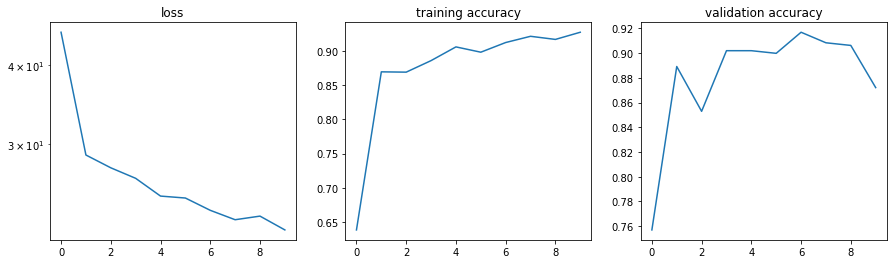

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.plot(losses[:-1])
ax1.set_yscale('log')
ax1.set_title('loss')
ax2.plot(accus_train[:-1])
ax2.set_title('training accuracy')
ax3.plot(accus_val)
ax3.set_title('validation accuracy');

In [18]:
# test accuracy (when use option2 dataloader)
# save_path = "/content/gdrive/MyDrive/Kaggle/CoronaHack/vit_10.pth"
# model = torch.load(save_path)
model.eval()

loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                          shuffle=False)
preds = []
with torch.no_grad():
  for x, t in loader_test:
    x, t = x.to(device), t.to(device) 
    logits = model(x)
    preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

accus_test = sum(preds) / len(test_dataset)
print(accus_test)

tensor(0.8785, device='cuda:0')


In [ ]:
save_path = "/content/gdrive/MyDrive/Kaggle/CoronaHack/vit_10.pth"
torch.save(model, save_path)

## Fine-Tuning: run train.py in the source code directly

In [ ]:
!git clone https://github.com/rwightman/pytorch-image-models.git

In [ ]:
data_dir = "/content/gdrive/MyDrive/pytorch-image-models/CoronaHack_data"
!mkdir $data_dir
normal_dir = f"{data_dir}/normal"
virus_dir = f"{data_dir}/virus"
# covid_dir = f"{data_dir}/covid19"
# other_dir = f"{data_dir}/other"
dir_dict = {
    normal_dir: normal_meta, 
    virus_dir: virus_meta,
    # covid_dir: covid_meta,
    # other_dir: other_meta,
}
for dir in dir_dict.keys():
  if not os.path.exists(dir):
    os.mkdir(dir)
old_data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack1/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"

for dir, meta in dir_dict.items():
  for im in meta["X_ray_image_name"]:
    if os.path.exists(f"{old_data_dir}/train/{im}"):
      os.rename(f"{old_data_dir}/train/{im}", f"{dir}/{im}")
    elif os.path.exists(f"{old_data_dir}/test/{im}"):
      os.rename(f"{old_data_dir}/test/{im}", f"{dir}/{im}")

In [ ]:
!sh distributed_train.sh 1 "CoronaHack_data" --model vit_base_patch16_224 --pretrained --img-size 128 --input-size 3 128 128 --num-classes 2 --epochs 20 -b 64